 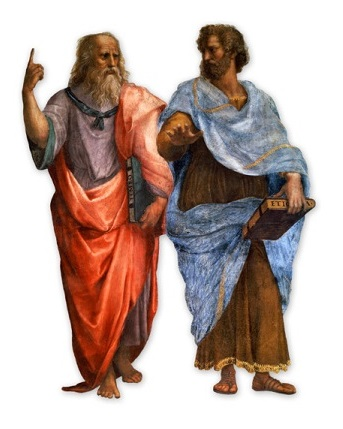

### Import TensorFlow and other libraries

In [1]:
import tensorflow as tf

import numpy as np
import os
import time

### Download the book (tf dataset)

Change the following line to run this code on your own data.

In [2]:
def save_dataset(dataset,fileName):
  path = os.path.join('./tfDatasets/', fileName)
  tf.data.experimental.save(dataset, path)

def load_dataset(fileName):
  path = os.path.join("./tfDatasets/", fileName)
  new_dataset = tf.data.experimental.load(path,
      tf.TensorSpec(shape=(), dtype=tf.string))
  return new_dataset

In [3]:
!curl -O https://www.gutenberg.org/cache/epub/1497/pg1497.txt
# !curl -O http://classics.mit.edu/Plato/republic.mb.txt
raw_data_ds = tf.data.TextLineDataset(["pg1497.txt"]) 
# "TextLineDataset" loads text from text files and creates a dataset where each line of the files becomes an element of the dataset.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1214k  100 1214k    0     0   550k      0  0:00:02  0:00:02 --:--:--  550k


simpler method : 

In [4]:
path_to_file = tf.keras.utils.get_file('pg1497.txt', 'https://www.gutenberg.org/cache/epub/1497/pg1497.txt')

1253376/1243940 [==============================] - 1s 1us/step


### reference https://www.tensorflow.org/text/tutorials/text_generation

### Read the data

First, look in the text:

In [5]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1238539 characters


In [6]:
# Take a look at the first 250 characters in text
print(text[:250])

﻿The Project Gutenberg eBook of The Republic, by Plato

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re


In [7]:
# The unique characters in the file
vocab = sorted(set(text))

print(f'{len(vocab)} unique characters')

116 unique characters


## Process the text

### 1-Text vectorization

we can't work with text representation for the neural network,we need to convert the text into a numerical representation

In [8]:
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

116 unique characters



The `tf.keras.layers.StringLookup` layer can convert each character into a numeric ID. It just needs the text to be split into tokens first.

In [9]:
char_to_ids = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

it  returns them as a tf.RaggedTensor of characters: A RaggedTensor is a tensor with one or more ragged dimensions, which are dimensions whose slices may have different lengths.

we also need to reverse the generated text, it will also be important to invert this representation and convert it to readable text.

For this you can use `tf.keras.layers.StringLookup(..., invert=True)`.  

instead of passing the original sorted vocabulary we use the `get_vocabulary()` method of the `tf.keras.layers.StringLookup` layer so that the `[UNK]` tokens is set the same way.

In [10]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=char_to_ids.get_vocabulary(), invert=True, mask_token=None)

This layer recovers the characters from the vectors of IDs, and returns them as a `tf.RaggedTensor` of characters:

`tf.strings.reduce_join`is used to join the characters back into strings. 

In [11]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### The prediction task

Given a character, or a sequence of characters, what is the most probable next character? This is the task you're training the model to perform. The input to the model will be a sequence of characters, and you train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?


### Create training examples and targets

Next divide the text into example sequences. Each input sequence will contain `seq_length` characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of `seq_length+1`. For example, say `seq_length` is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices.

In [12]:
all_ids = char_to_ids(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1238539,), dtype=int64, numpy=array([116,  51,  67, ...,   1,   2,   1])>

In [13]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [14]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

﻿
T
h
e
 
P
r
o
j
e


In [15]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

The `batch` method lets you easily convert these individual characters to sequences of the desired size.

In [16]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'\xef\xbb\xbf' b'T' b'h' b'e' b' ' b'P' b'r' b'o' b'j' b'e' b'c' b't'
 b' ' b'G' b'u' b't' b'e' b'n' b'b' b'e' b'r' b'g' b' ' b'e' b'B' b'o'
 b'o' b'k' b' ' b'o' b'f' b' ' b'T' b'h' b'e' b' ' b'R' b'e' b'p' b'u'
 b'b' b'l' b'i' b'c' b',' b' ' b'b' b'y' b' ' b'P' b'l' b'a' b't' b'o'
 b'\r' b'\n' b'\r' b'\n' b'T' b'h' b'i' b's' b' ' b'e' b'B' b'o' b'o' b'k'
 b' ' b'i' b's' b' ' b'f' b'o' b'r' b' ' b't' b'h' b'e' b' ' b'u' b's'
 b'e' b' ' b'o' b'f' b' ' b'a' b'n' b'y' b'o' b'n' b'e' b' ' b'a' b'n'
 b'y' b'w' b'h' b'e' b'r'], shape=(101,), dtype=string)


It's easier to see what this is doing if you join the tokens back into strings:

In [17]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'\xef\xbb\xbfThe Project Gutenberg eBook of The Republic, by Plato\r\n\r\nThis eBook is for the use of anyone anywher'
b'e in the United States and\r\nmost other parts of the world at no cost and with almost no restrictions\r'
b'\nwhatsoever. You may copy it, give it away or re-use it under the terms\r\nof the Project Gutenberg Lic'
b'ense included with this eBook or online at\r\nwww.gutenberg.org. If you are not located in the United S'
b'tates, you\r\nwill have to check the laws of the country where you are located before\r\nusing this eBook'


before we develop our model we need to define our input and outputs

We can split the text into (input & label) :
* **input** is the current letter 
* **label** is the next letter


In [18]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [19]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [20]:
dataset = sequences.map(split_input_target)

In [21]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'\xef\xbb\xbfThe Project Gutenberg eBook of The Republic, by Plato\r\n\r\nThis eBook is for the use of anyone anywhe'
Target: b'The Project Gutenberg eBook of The Republic, by Plato\r\n\r\nThis eBook is for the use of anyone anywher'


notice in the 1st line "anywhere" is missing the r (anywhe), the target is the whole line including the next char (anywher) 

### Create training batches

before feeding this data into the model,we need to shuffle and split the data into batches.

In [22]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE) # shuffle the data 
    .batch(BATCH_SIZE, drop_remainder=True) # batch size 
    .prefetch(tf.data.experimental.AUTOTUNE)) # used for optimization 

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

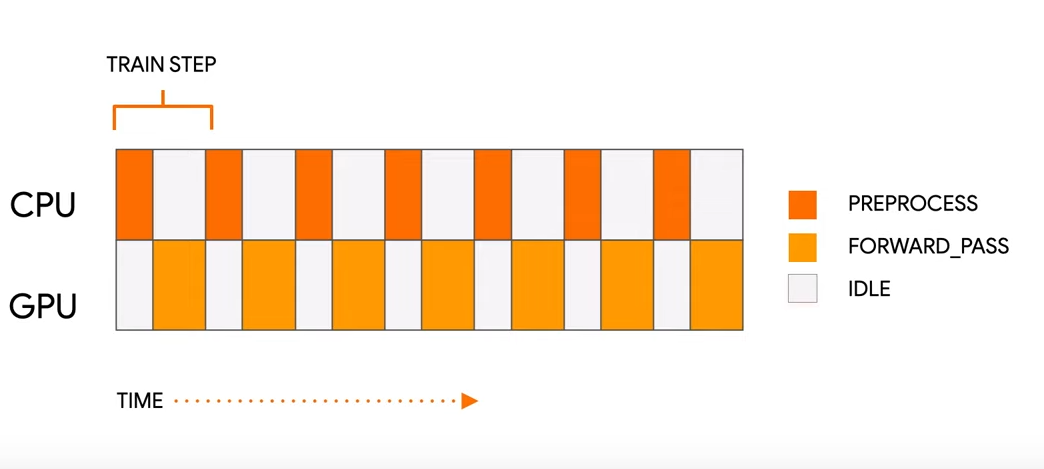
 https://www.youtube.com/watch?v=GVShIIh3_yE #official TF youtube channel

normally when we are using preprocessing layer, the preprocessing happens on the CPU, meanwhile the gpu sits there doing nothing waiting the next batch, to optimize this we are using prefetch 

**Prefetching** overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

## Build The Model

for this part we followed the official tensorflow guidline for custom subclass  model 

https://www.tensorflow.org/guide/keras/custom_layers_and_models

This model has only three layers:

* `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map each character-ID to a vector with `embedding_dim` dimensions;
* `tf.keras.layers.GRU`: A type of RNN with size `units=rnn_units` (for our 1st model we choosed GRU but we can also choose LSTM here.)
* `tf.keras.layers.Dense`: The fully connected layer, with `vocab_size` outputs. It outputs one logit for each character in the vocabulary. These are the log-likelihood of each character according to the model.

later when we come to the generation part the model will the char with the highest log-liklihood 

In [23]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 50

# Number of RNN units
rnn_units = 1024

In [58]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [59]:
model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(char_to_ids.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

## Try the model

Now run the model to see that it behaves as expected.

First check the shape of the output:

In [60]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 117) # (batch_size, sequence_length, vocab_size)


In the above example the sequence length of the input is `100` but the model can be run on inputs of any length:

In [61]:
model.summary()

Model: "my_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  5850      
                                                                 
 gru_1 (GRU)                 multiple                  3305472   
                                                                 
 dense_2 (Dense)             multiple                  119925    
                                                                 
Total params: 3,431,247
Trainable params: 3,431,247
Non-trainable params: 0
_________________________________________________________________


To get actual predictions from the model you need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

Note: It is important to _sample_ from this distribution as taking the _argmax_ of the distribution can easily get the model stuck in a loop.

Try it for the first example in the batch:

In [28]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [29]:
sampled_indices

array([ 73,  50,  86, 103,  94,  89,  43, 115,  60,  73,  19, 112,  62,
        70, 109,  42,  79,  50,   8, 111,  55, 107,  49,  95,   4,  15,
        34,  26,   6, 116,  60, 101,  92,  39,  73,  63, 116,  62,  14,
       114,  35, 100,  83,  40, 100,  94, 108,  31,  44,  59, 103,  24,
        74,  42,  74,  58, 108,  44,  81,   7,  36,   6,  35, 107,  79,
        59,  66,  81,   1, 101,  38,  28,   5,  89,  16, 103,   5,  12,
         1,   4,  60,  81,  39,   5,  19,  94,  39,  57,  88,   6, 109,
        98,  87,  68,  87,  86,   6,  79,  78,  95])

Decode these to see the text predicted by this untrained model:

In [30]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'ally given...suppressed and\r\nended.\xe2\x80\x99) He ridicules the new logic of his time; the Utopians could\r\nne'

Next Char Predictions:
 b'nS\xc3\xa4\xe1\xbc\x90\xce\xbf\xce\xb5L\xe2\x80\x9dan1\xe2\x80\x98ck\xe1\xbf\xb6KtS%\xe2\x80\x94X\xe1\xbd\xb7R\xcf\x80!-C8#\xef\xbb\xbfa\xcf\x87\xce\xbdHnd\xef\xbb\xbfc,\xe2\x80\x9cD\xcf\x86xI\xcf\x86\xce\xbf\xe1\xbd\xb8?M]\xe1\xbc\x906oKo[\xe1\xbd\xb8Mv$E#D\xe1\xbd\xb7t]gv\n\xcf\x87G:"\xce\xb5.\xe1\xbc\x90"*\n!avH"1\xce\xbfHZ\xce\xb2#\xe1\xbf\xb6\xcf\x83\xce\xb1i\xce\xb1\xc3\xa4#ts\xcf\x80'


## Train the model

now it's just a classification problem, given the previous state and the time step we need to predict the class of the next charachter, then generate multiple predictions and concatenate these charchters into words and decode it to get our text

### choose optimizer, and a loss function

as a multi class classification we use `sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions.




In [31]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True) 
# our model returns log liklihoods so we need to set the `from_logits` flag to true.

In [32]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 117)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.7622223, shape=(), dtype=float32)


to set the learn rate automatically we choose adam optimizer 

In [33]:
model.compile(optimizer='adam', loss=loss)

### Configure checkpoints

Use a `tf.keras.callbacks.ModelCheckpoint` to ensure that checkpoints are saved during training:

In [34]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Execute the training

In [35]:
EPOCHS = 30

In [36]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
191/191 [==============================] - 33s 129ms/step - loss: 2.8980
Epoch 2/20
191/191 [==============================] - 26s 126ms/step - loss: 2.1035
Epoch 3/20
191/191 [==============================] - 26s 126ms/step - loss: 1.8050
Epoch 4/20
191/191 [==============================] - 26s 125ms/step - loss: 1.5538
Epoch 5/20
191/191 [==============================] - 26s 126ms/step - loss: 1.3892
Epoch 6/20
191/191 [==============================] - 25s 125ms/step - loss: 1.2897
Epoch 7/20
191/191 [==============================] - 26s 126ms/step - loss: 1.2229
Epoch 8/20
191/191 [==============================] - 26s 125ms/step - loss: 1.1722
Epoch 9/20
191/191 [==============================] - 26s 125ms/step - loss: 1.1308
Epoch 10/20
191/191 [==============================] - 26s 125ms/step - loss: 1.0925
Epoch 11/20
191/191 [==============================] - 25s 125ms/step - loss: 1.0561
Epoch 12/20
191/191 [==============================] - 26s 125ms/step - lo

## Generate text

steps for generating text 

1- create a function to predict the next charachter 

2- apply the temprature 

3- apply mask to prevent "UNK" generation 

4- Run the function inside a loop to generate some text.

Each time the function is called. The model returns a prediction for the next character and its new state. 

Pass the prediction and state back in to continue generating text.


#single step prediction:

In [37]:
#https://www.tensorflow.org/text/tutorials/text_generation

class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, char_to_ids, temperature=1.0):
    super().__init__()
    self.temperature = temperature # this is a hyperparameter to choose how much randomness does our model produce 
    self.model = model # the defined model
    self.chars_from_ids = chars_from_ids # the tokinized chars
    self.char_to_ids = char_to_ids 

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.char_to_ids(['[UNK]'])[:, None] # to generate space that seperates each word from the next 
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids), # when the model compeletes a full word it skips creating ids
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(char_to_ids.get_vocabulary())]) # match the created id to a prediction 
    self.prediction_mask = tf.sparse.to_dense(sparse_mask) 

  @tf.function
  def generate_one_step(self, inputs, states=None): # a function that predicts the next char 
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.char_to_ids(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states, # choose the token with the highest log liklihood
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :] 
    predicted_logits = predicted_logits/self.temperature # assign the temprature 
    
    predicted_logits = predicted_logits + self.prediction_mask # since the funtion will get called repeatedly we Apply the prediction mask to prevent "[UNK]" from being generated. 
    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [38]:
one_step_model = OneStep(model, chars_from_ids, char_to_ids) # invoking the class

to test the model understanding of plato's writing i chose one of my favourite quotes of his as a seed

In [53]:
seed_text = 'reality is created by the mind, we can change our reality by changing our '

In [54]:
start = time.time()
states = None
next_char = tf.constant([seed_text])
result = [next_char]

for n in range(50):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

reality is created by the mind, we can change our reality by changing our evils of
things which produce a larger science?’  

________________________________________________________________________________

Run time: 0.3204164505004883


as we can see, the model actually captures some of the writing vibe of plato's , it's actually pretty "deep" and true but obiously not gramatically correct

"reality is created by the mind, we can change our reality by changing our mind" - plato 

<


reality is created by the mind, we can change our reality by changing our evils of things which produce a larger science?’ -rnn model

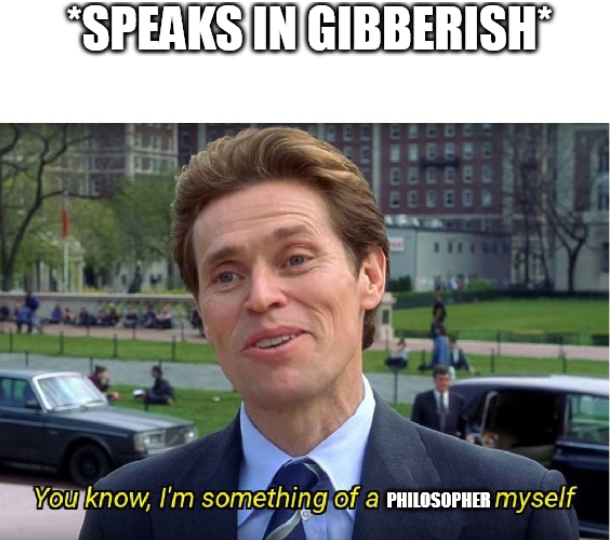

there is still room for improvements which may include :  
1- **training for more epoches**


2-**adding more LSTM layers**


3-**adjust the temperature parameter to generate more or less random predictions.**

4-**using pretrained transformer models (GPT3- huggingface pipeline)** # https://keras.io/examples/generative/text_generation_with_miniature_gpt/



#references :

https://keras.io/examples/generative/lstm_character_level_text_generation/

https://www.tensorflow.org/text/tutorials/text_generation

https://www.youtube.com/watch?v=GVShIIh3_yE #official TF youtube channel

https://www.tensorflow.org/guide/keras/custom_layers_and_models

